In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

import warnings
# Ignorar os warnings
warnings.filterwarnings("ignore")

import time

#PYOD
from pyod.models.knn import KNN 
from pyod.models.ocsvm import OCSVM
from pyod.models.lof import LOF
from pyod.models.inne import INNE

## PYOD

In [2]:
def def_metricas(test_y, y_test_pred, y_test_scores):
    # Calcula as métricas de avaliação
    precision = precision_score(test_y, y_test_pred)
    recall = recall_score(test_y, y_test_pred)
    f1 = f1_score(test_y, y_test_pred)
    accuracy = accuracy_score(test_y, y_test_pred)
    auc = roc_auc_score(test_y, y_test_scores)

    metricas = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall':recall,
        'F1':f1,
        'AUC':auc
    }
    
    return metricas

In [3]:
def print_results(user, clf_name, best_param, best_windows, results):
    print("Usuário:", user)
    print("Modelo:", clf_name)
    print("Melhor Parametro:", best_param)
    print("Janela:", best_windows)
    print(f"Acurácia: {results['Accuracy']}")
    print(f"Precisão: {results['Precision']}")
    print(f"Recall: {results['Recall']}")
    print(f"F1: {results['F1']}")
    print(f"AUC: {results['AUC']}")

In [4]:
def get_model(model_name, params_dict):
        
    if model_name == 'KNN':
        model = KNN(**params_dict)
    if model_name == 'OCSVM':
        model = OCSVM(**params_dict)
    if model_name == 'LOF':
        model = LOF(**params_dict)
    if model_name == 'INNE':
        model = INNE(**params_dict)
    
    print(f"Modelo: {model}")
    return model

def process_data(genuino, impostor, validacao):
    start_process = time.time()
    # Salvar o novo dataset com as janelas

    train_df = genuino.copy()
    test_df = impostor.copy()
    validacao_df = validacao.copy()
        
    scaler = StandardScaler()

    # Normalização
    cols = train_df.columns
    sc_train = scaler.fit_transform(train_df.values)
    sc_test = scaler.transform(test_df.values)
    sc_validacao = scaler.transform(validacao_df.values)

    # Salvar a normalização
    train_df = pd.DataFrame(sc_train, columns=cols)
    test_df = pd.DataFrame(sc_test, columns=cols)
    validacao_df = pd.DataFrame(sc_validacao, columns=cols)

    # Teste
    n = round(len(train_df) * 0.30)
    add = train_df.tail(n)  # 30%
    # Apagar as linhas do df de treino que foram utilizadas no teste
    train_df.drop(add.index, inplace=True)
    
    test_df = test_df.append(add, ignore_index=True)

    #Validação
    n = round(len(train_df) * 0.20)
    add2 = train_df.tail(n) #20%

    val_df = pd.concat([add2, validacao_df], ignore_index=True)
    # Apaga as linhas do df de treino que foram utilizadas no teste
    train_df.drop(add2.index, inplace=True)

    
    end_process = time.time()
    print("Tempo de execução do processamento: ", end_process - start_process)

    return train_df, val_df, test_df

# Recebe modelo, dados e retorna metricas da execucao do modelo
def exec_model(model, train_df, val_test_df):
    start_exec = time.time()

    train = train_df.copy()
    val_test = val_test_df.copy()

    # Remove label do treino
    train = train.iloc[:,:-1]

    # Coleta e remove label do set de validacao ou teste
    val_test_y = val_test['label']
    val_test = val_test.iloc[:,:-1]

    model.fit(train)

    y_val_test_pred = model.predict(val_test)  # Outlier labels (0 ou 1)
    y_val_test_scores = model.decision_function(val_test)  # Outlier scores

    result_metrics = def_metricas(val_test_y, y_val_test_pred, y_val_test_scores)

    end_exec = time.time()
    print("Tempo de execução do modelo: ", end_exec - start_exec)

    return result_metrics

def best_exec(metrics):
    f1_scores = [metric['scores']['F1'] for metric in metrics]
    best_param_idx = np.argmax(f1_scores)
    return metrics[best_param_idx].values()

def grid_search(model_name, param_grid, processed_data_windows, window_size_list):
    start_grid = time.time()
    metrics = []
    param_grid = ParameterGrid(param_grid)
    for window_size in window_size_list:
        print(f"---> Executando com a janela {window_size}...")
        #train_df, val_df, _ = process_data(genuine, impostor, window_size)
        train_df, val_df, _ =  processed_data_windows[window_size]
        
        for params_dict in param_grid:
            print(f"Executando com os parametros {params_dict}...")
            model = get_model(model_name, params_dict)
            scores = exec_model(model, train_df, val_df)
            print(f"Obteve o f1_score = {scores['F1']} \n ---------------------- ")
            metrics.append({'scores': scores, 'params': params_dict, 'window_size': window_size})

    end_grid = time.time()
    print("Tempo de execução GridSearch: ", end_grid - start_grid)
    
    return metrics


In [5]:
# Lista de usuarios
users = [
    'enrolment_01',
    'enrolment_02',
    'enrolment_03',
    'enrolment_04',
    'enrolment_05',
    'enrolment_06',
    'enrolment_07',
    'enrolment_08',
    'enrolment_09',
    'enrolment_10',
    'enrolment_11',
    'enrolment_12',
    'enrolment_13',
    'enrolment_14',
    'enrolment_15',
    'enrolment_16',
    'enrolment_17',
    'enrolment_18',
    'enrolment_19',
    'enrolment_20'
]

# Lista de tamanhos de janela
window_size_list = [1,2,3,4,5,6,7]

# Lista de parâmetros para cada modelo
models_params_grid = {
    'KNN': {
        'n_neighbors': [5, 10, 15, 20, 25],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algoritmo utilizado para calcular os vizinhos mais próximos
        #'leaf_size': [30, 40, 50, 60, 70],  # Tamanho da folha usado para construir a árvore de vizinhos
    },
    'OCSVM': {
        'nu': [0.1, 0.2, 0.3, 0.4, 0.5],
        'kernel': ['linear', 'rbf', 'sigmoid'],  # Tipo de kernel utilizado
        'gamma': ['scale', 'auto'],  # Parâmetro de escala do kernel
    },
    'LOF': {
        'n_neighbors': [5, 10, 15, 20, 25],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algoritmo utilizado para calcular os vizinhos mais próximos
        'leaf_size': [30, 40, 50, 60, 70],  # Tamanho da folha usado para construir a árvore de vizinhos
    },
    'INNE': {
        'n_estimators': [80, 100, 125, 135, 150],
        }
}

user_models_results = {}

for user in users:

    user_models_results[user] = {}
    processed_data_windows = {} #salva as janelas

    for window_size in window_size_list:

        genuine = pd.read_csv('datasets_skilled/' + user + '_train_data_window_' + str(window_size) + '.csv')
        impostor = pd.read_csv('datasets_skilled/' + user + '_test_data_window_' + str(window_size) + '.csv')
        validacao = pd.read_csv('datasets_validation/val_data_window_' + str(window_size) + '.csv') 

        print(f"Processando os dados do usuário: {user} com tamanho de janela: {window_size}")

        train_df, val_df, test_df = process_data(genuine, impostor, validacao)
        processed_data_windows[window_size] = (train_df, val_df, test_df)


    for clf_name in models_params_grid:
        print(f"============================================== \n Executando o modelo {clf_name} para o usuario {user} com os parametros {models_params_grid[clf_name]}...")

        # Grid search with val set
        metrics = grid_search(clf_name, models_params_grid[clf_name], processed_data_windows, window_size_list)

        #TODO: criar uma funcao para visualizar as metricas por janela por modelo por hiperparametro
        #plota_metricas(metrics)

        # Test exec
        _, best_params, best_window_size = best_exec(metrics)
        
        print("\n=========================TESTE===============================")
        print(f"============================================== \n Executando o modelo {clf_name} para o usuario {user} com os parametros {best_params} e janela {best_window_size}...")

        model = get_model(clf_name, best_params)

        # train_df, _, test_df = process_data(genuine, impostor, best_window_size)
        train_df, _, test_df = processed_data_windows[best_window_size]

        results = exec_model(model, train_df, test_df)
        
        user_models_results[user][clf_name] = {}
        user_models_results[user][clf_name]['results'] = results
        user_models_results[user][clf_name]['best_params'] = best_params
        user_models_results[user][clf_name]['best_window_size'] = best_window_size
        
        
        print("\n========================================================\n")
        print("\nResultados finais: \n")
        print_results(user, clf_name, best_params, best_window_size, results)
        print("\n========================================================\n")

Processando os dados do usuário: enrolment_01 com tamanho de janela: 1
Tempo de execução do processamento:  0.3293449878692627
Processando os dados do usuário: enrolment_01 com tamanho de janela: 2
Tempo de execução do processamento:  0.012998819351196289
Processando os dados do usuário: enrolment_01 com tamanho de janela: 3
Tempo de execução do processamento:  0.0154266357421875
Processando os dados do usuário: enrolment_01 com tamanho de janela: 4
Tempo de execução do processamento:  0.016988754272460938
Processando os dados do usuário: enrolment_01 com tamanho de janela: 5
Tempo de execução do processamento:  0.014509201049804688
Processando os dados do usuário: enrolment_01 com tamanho de janela: 6
Tempo de execução do processamento:  0.019550323486328125
Processando os dados do usuário: enrolment_01 com tamanho de janela: 7
Tempo de execução do processamento:  0.015994548797607422
 Executando o modelo KNN para o usuario enrolment_01 com os parametros {'n_neighbors': [5, 10, 15, 20

In [6]:
import pprint

pprint.pprint(user_models_results)

{'enrolment_01': {'INNE': {'best_params': {'n_estimators': 125},
                           'best_window_size': 1,
                           'results': {'AUC': 1.0,
                                       'Accuracy': 0.9827814569536424,
                                       'F1': 0.9907473309608541,
                                       'Precision': 0.9816643159379408,
                                       'Recall': 1.0}},
                  'KNN': {'best_params': {'algorithm': 'auto',
                                          'n_neighbors': 15},
                          'best_window_size': 1,
                          'results': {'AUC': 1.0,
                                      'Accuracy': 1.0,
                                      'F1': 1.0,
                                      'Precision': 1.0,
                                      'Recall': 1.0}},
                  'LOF': {'best_params': {'algorithm': 'auto',
                                          'leaf_size': 30,
         

In [7]:
best_window_sizes_by_user = {}
for user in user_models_results:
    best_window_sizes_by_user[user] = {}
    for clf_name in user_models_results[user]:
        try:
            best_window_sizes_by_user[user][user_models_results[user][clf_name]['best_window_size']] += 1
        except KeyError:
            best_window_sizes_by_user[user][user_models_results[user][clf_name]['best_window_size']] = 1

best_window_sizes_by_user

{'enrolment_01': {1: 4},
 'enrolment_02': {5: 2, 7: 2},
 'enrolment_03': {1: 3, 7: 1},
 'enrolment_04': {1: 2, 7: 1, 6: 1},
 'enrolment_05': {3: 2, 1: 2},
 'enrolment_06': {7: 3, 1: 1},
 'enrolment_07': {7: 4},
 'enrolment_08': {6: 1, 7: 3},
 'enrolment_09': {1: 4},
 'enrolment_10': {7: 1, 2: 2, 1: 1},
 'enrolment_11': {1: 1, 4: 2, 2: 1},
 'enrolment_12': {2: 1, 6: 1, 3: 1, 5: 1},
 'enrolment_13': {4: 1, 6: 1, 7: 1, 2: 1},
 'enrolment_14': {7: 4},
 'enrolment_15': {1: 1, 7: 2, 5: 1},
 'enrolment_16': {7: 1, 4: 1, 5: 1, 2: 1},
 'enrolment_17': {7: 2, 5: 2},
 'enrolment_18': {2: 1, 5: 1, 4: 1, 1: 1},
 'enrolment_19': {1: 3, 2: 1},
 'enrolment_20': {1: 3, 2: 1}}

In [8]:
global_best_window_sizes = {}

for user in best_window_sizes_by_user:
    for window_size in best_window_sizes_by_user[user]:
        try:
            global_best_window_sizes[window_size] += best_window_sizes_by_user[user][window_size]
        except KeyError:
            global_best_window_sizes[window_size] = best_window_sizes_by_user[user][window_size]

global_best_window_sizes

{1: 26, 5: 8, 7: 25, 6: 4, 3: 3, 2: 9, 4: 5}

In [9]:
accuracy = []
auc = []
precision = []
f1 = []
recall = []

windows = []

metrics_by_windows = {}

for clf_name in models_params_grid:
    metrics_by_windows[clf_name] = {}
    for user in user_models_results:
        auc.append(user_models_results[user][clf_name]['results']['AUC'])
        accuracy.append(user_models_results[user][clf_name]['results']['Accuracy'])
        f1.append(user_models_results[user][clf_name]['results']['F1'])
        precision.append(user_models_results[user][clf_name]['results']['Precision'])
        recall.append(user_models_results[user][clf_name]['results']['Recall'])
        windows.append(user_models_results[user][clf_name]['best_window_size'])
    
    for i in range(len(windows)):
        try:
            metrics_by_windows[clf_name][windows[i]]['auc'].append(auc[i])
            metrics_by_windows[clf_name][windows[i]]['accuracy'].append(accuracy[i])
            metrics_by_windows[clf_name][windows[i]]['f1'].append(f1[i])
            metrics_by_windows[clf_name][windows[i]]['precision'].append(precision[i])
            metrics_by_windows[clf_name][windows[i]]['recall'].append(recall[i])
        except KeyError:
            metrics_by_windows[clf_name][windows[i]] = {'auc': [auc[i]], 'accuracy': [accuracy[i]], 'f1': [f1[i]], 'precision': [precision[i]], 'recall': [recall[i]]}

    print(clf_name)
    print(" Média AUC: ", np.mean(auc),
        "\n Média Accuracy: ", np.mean(accuracy),
        "\n Média F1-Score: ", np.mean(f1),
        "\n Média Precision: ", np.mean(precision),
        "\n Média Recall: ", np.mean(recall),
        "\n============================"        
        )

KNN
 Média AUC:  0.9854546084332751 
 Média Accuracy:  0.9012419318766446 
 Média F1-Score:  0.931376790930891 
 Média Precision:  0.9365728661332753 
 Média Recall:  0.9415071316559303 
OCSVM
 Média AUC:  0.9572639844787064 
 Média Accuracy:  0.8892028999392352 
 Média F1-Score:  0.9159469551206033 
 Média Precision:  0.9027067598806642 
 Média Recall:  0.9402499021419407 
LOF
 Média AUC:  0.9564091600728156 
 Média Accuracy:  0.8873234355760273 
 Média F1-Score:  0.917239798527719 
 Média Precision:  0.9056534780407818 
 Média Recall:  0.9415973387912085 
INNE
 Média AUC:  0.9532647127160289 
 Média Accuracy:  0.8861867498965836 
 Média F1-Score:  0.9192354490077836 
 Média Precision:  0.9051635827043552 
 Média Recall:  0.9455532870532032 


In [10]:
pprint.pprint(metrics_by_windows)

{'INNE': {1: {'accuracy': [1.0,
                           0.955108359133127,
                           0.9330143540669856,
                           0.8780487804878049,
                           0.9396135265700483,
                           0.6830985915492958,
                           0.9702127659574468,
                           0.9853658536585366,
                           0.9986754966887417,
                           0.955108359133127,
                           0.8634920634920635,
                           0.8588850174216028,
                           0.9960264900662251,
                           0.9210526315789473,
                           0.9217391304347826,
                           0.8658536585365854,
                           0.9617563739376771,
                           0.9957446808510638,
                           0.8422764227642277,
                           0.9827814569536424,
                           0.8637770897832817,
                           0.9

In [11]:
for model in metrics_by_windows:
     for janela in metrics_by_windows[model]:
           print(f"\nAcurácia média do modelo {model} na janela {janela}")
           print(np.mean(metrics_by_windows[model][janela]['accuracy']))
           print("Desvio padrão")
           print(np.std(metrics_by_windows[model][janela]['accuracy']))

           print(f"\nAUC média do modelo {model} na janela {janela}")
           print(np.mean(metrics_by_windows[model][janela]['auc']))
           print("Desvio padrão")
           print(np.std(metrics_by_windows[model][janela]['auc']))

           print(f"\nF1-Score média do modelo {model} na janela {janela}")
           print(np.mean(metrics_by_windows[model][janela]['f1']))
           print("Desvio padrão")
           print(np.std(metrics_by_windows[model][janela]['f1']))

           print(f"\nPrecisão média do modelo {model} na janela {janela}")
           print(np.mean(metrics_by_windows[model][janela]['precision']))
           print("Desvio padrão")
           print(np.std(metrics_by_windows[model][janela]['precision']))

           print(f"\nRecall média do modelo {model} na janela {janela}")
           print(np.mean(metrics_by_windows[model][janela]['recall']))
           print("Desvio padrão")
           print(np.std(metrics_by_windows[model][janela]['recall']))

           print("\n---------------------------------------------------")


Acurácia média do modelo KNN na janela 1
0.9180577789279056
Desvio padrão
0.09541533011646157

AUC média do modelo KNN na janela 1
1.0
Desvio padrão
0.0

F1-Score média do modelo KNN na janela 1
0.9466027367216456
Desvio padrão
0.06521452136431735

Precisão média do modelo KNN na janela 1
0.9051839035001403
Desvio padrão
0.10617627455394696

Recall média do modelo KNN na janela 1
1.0
Desvio padrão
0.0

---------------------------------------------------

Acurácia média do modelo KNN na janela 5
0.7360248447204969
Desvio padrão
0.0

AUC média do modelo KNN na janela 5
0.8922875319206129
Desvio padrão
0.0

F1-Score média do modelo KNN na janela 5
0.761904761904762
Desvio padrão
0.0

Precisão média do modelo KNN na janela 5
1.0
Desvio padrão
0.0

Recall média do modelo KNN na janela 5
0.6153846153846154
Desvio padrão
0.0

---------------------------------------------------

Acurácia média do modelo KNN na janela 3
0.9590643274853801
Desvio padrão
0.0

AUC média do modelo KNN na janela 3


In [12]:
# for model in metrics_by_windows:
#      for janela in metrics_by_windows[model]:
#            print(f"Modelo {model} na janela {janela}\n")
           
#            print(np.mean(metrics_by_windows[model][janela]['auc']))
           
#            print(np.mean(metrics_by_windows[model][janela]['accuracy']))

#            print(np.mean(metrics_by_windows[model][janela]['f1']))

#            print(np.mean(metrics_by_windows[model][janela]['precision']))

#            print(np.mean(metrics_by_windows[model][janela]['recall']))

#            print("\n---------------------------------------------------")

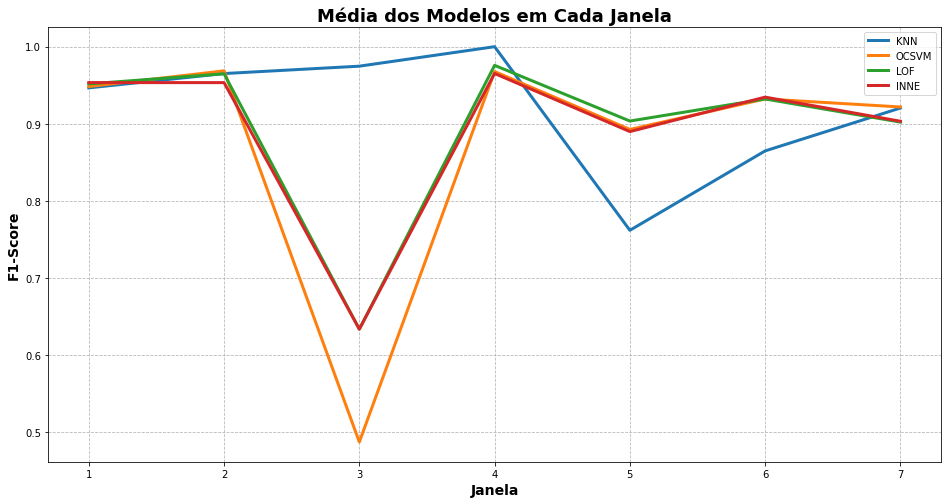

In [15]:
import matplotlib.pyplot as plt

# Criar uma nova figura com tamanho maior
plt.figure(figsize=(16, 8))

# Imprimir a média das métricas por janela x modelo
for model in metrics_by_windows:
    result_plot = []
    window_plot = []
    for janela in metrics_by_windows[model]:
        result_plot.append(np.mean(metrics_by_windows[model][janela]['f1']))
        window_plot.append(janela)

    # Organiza a sequência das janelas
    window_plot, result_plot = zip(*sorted(zip(window_plot, result_plot)))

    plt.plot(window_plot, result_plot, label=model, linewidth=3, linestyle='-')

plt.title("Média dos Modelos em Cada Janela", fontweight="bold", fontsize=18)
plt.grid(True, linestyle='--', alpha=0.9)
plt.legend()
plt.xlabel("Janela", fontweight="bold", fontsize=14)
plt.ylabel("F1-Score", fontweight="bold", fontsize=14)
plt.savefig('media_f1.png', facecolor='w')

plt.show()


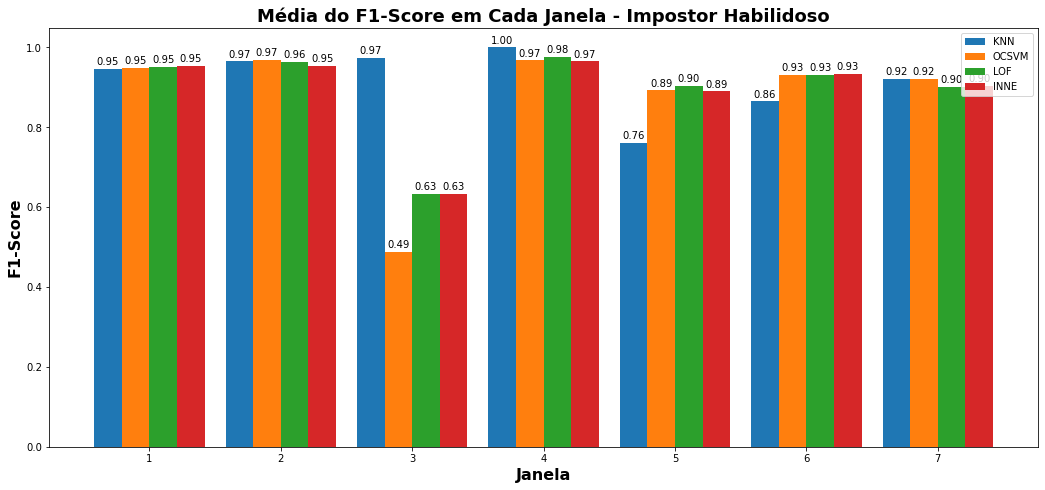

In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(layout='constrained', figsize=(18, 8))

# Defina a largura das colunas
width = 0.21

# Crie um deslocamento para posicionar as colunas lado a lado
offsets = np.linspace(-width*1.5, width*1.5, len(metrics_by_windows))

for index, model in enumerate(metrics_by_windows):
    result_plot = []
    window_plot = []
    for janela in metrics_by_windows[model]:
        result_plot.append(np.mean(metrics_by_windows[model][janela]['f1']))
        window_plot.append(janela)
    
    # Organiza a sequência das janelas usando numpy.argsort()
    sorted_indices = np.argsort(window_plot)
    window_plot = np.array(window_plot)[sorted_indices]
    result_plot = np.array(result_plot)[sorted_indices]

    # Posicione as colunas lado a lado usando o deslocamento
    x_positions = [pos + offsets[index] for pos in np.arange(len(window_plot))]

    rects = ax.bar(x_positions, result_plot, width=width, label=model)
    
    # Rotule as barras com os valores formatados com duas casas decimais
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',  # Formatação com duas casas decimais
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # Deslocamento vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

# Defina os rótulos do eixo x para as janelas
ax.set_xticks(np.arange(len(window_plot)))
ax.set_xticklabels(window_plot)

plt.title("Média do F1-Score em Cada Janela - Impostor Habilidoso", fontweight="bold", fontsize=18)
plt.legend()
plt.xlabel("Janela", fontweight="bold", fontsize=16)
plt.ylabel("F1-Score", fontweight="bold", fontsize=16)
plt.savefig('graphic_skilled.png', facecolor='w')

plt.tight_layout()  # Ajuste automático da disposição para evitar sobreposições
plt.show()
